# Jigsaw puzzle
According to the [GWHD paper](https://arxiv.org/pdf/2005.02162.pdf) the images were split into 1024x1024 squared patches containing roughly 20 to 60 heads with only a few heads crossing the edges.
![gwhd_1](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F864684%2F9068f7f8dd526caa3657407c477e418f%2Fgwhd_splits.jpg?generation=1589069353753211&alt=media)

In this notebook you can find a raw code to solve this jigsaw puzzle.

## How it works
- From all of the images, it saves the left, right, top, and bottom edges. (1x2 has only left-right edges)
- In all possible combinations, it calculates a cosine distance (simple brute force algorithm)
- In the case of 1x2, it saves the top n matches.
- In the case of 2x2, it calculates a distance-sum on all possible (and valid) combination
- Store the top n matches
- Note: It generates only for one source per run. You have to modify the `TARGET` config (see below) and re-run everything.

## Limitations:
- The images from the `arvalis_3` source have very similar edges (mostly brown dirt), and this script won't work. (If you have any idea how to solve this, please leave me a comment)
- The `arvalis_1` and the `rres_1` sources have 2x3 patches (see the image above), this code is not working with 2x3 patches yet
- There are a few issues with the bounding boxes around edges. Ideally, we should merge the split boxes.

## Notations:
- **cX** columns in the generated files mean cell-X (for example 2x2: c1=top left, c2=bottom left, c3=top-right, c4=bottom-right). The values in theses columns are the original image id-s.

## TODO:
- 2x3 solution
- Merging the split boxes
- Create box dataframe with the same format we already have
- Fixing `arvalis_3` bug
- Create a dataset


In [21]:
import pandas as pd
import numpy as np
import cv2
import os
import ast
import hashlib
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine
%matplotlib inline

# Do not modify these!
TARGETS = ['arvalis_1', 'arvalis_2', 'arvalis_3', 'inrae_1', 'usask_1', 'rres_1', 'ethz_1']
N_PATCH = [(2, 3), (2, 2), (2, 2), (2, 2), (1, 2), (2, 3), (1, 2)]
THRESHOLDS = [0.0, 0.12, 0.0, 0.1, 0.12, 0.0, 0.12]
N_FULL_SIZE_IMAGES = [239, 51, 152, 44, 100, 72, 375]

In [22]:
# ======================================
# Set these values for your environment
# ======================================
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# Target source index (see above: TARGETS)
# Currently working: [1, *2, 3, 4, 6]
# *Image similarity issue with arvalis_3 (idx: 2)
TARGET = 3

# On Kaggle the script won't save images
IS_KAGGLE_ENV = True

# DIR_TARGET_ROOT = f'{DIR_INPUT}/full_images'
DIR_TARGET_ROOT = './'

In [23]:
train_df = pd.read_csv(f"{DIR_INPUT}/train.csv")
train_df = train_df[train_df['source'] == TARGETS[TARGET]]
train_df.reset_index(drop=True, inplace=True)

image_ids = train_df['image_id'].unique()

# From Andrew's kernel
train_df[['x', 'y', 'w', 'h']] = pd.DataFrame(
    np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))).astype(np.float32)
train_df['x1'] = train_df['x'] + train_df['w']
train_df['y1'] = train_df['y'] + train_df['h']

train_df.head()

image_id  width  height                          bbox   source      x  \
0  9b783b776   1024    1024   [217.0, 939.0, 118.0, 85.0]  inrae_1  217.0   
1  9b783b776   1024    1024  [394.0, 775.0, 112.0, 103.0]  inrae_1  394.0   
2  9b783b776   1024    1024   [266.0, 642.0, 97.0, 143.0]  inrae_1  266.0   
3  9b783b776   1024    1024   [706.0, 576.0, 128.0, 79.0]  inrae_1  706.0   
4  9b783b776   1024    1024  [104.0, 215.0, 180.0, 130.0]  inrae_1  104.0   

       y      w      h     x1      y1  
0  939.0  118.0   85.0  335.0  1024.0  
1  775.0  112.0  103.0  506.0   878.0  
2  642.0   97.0  143.0  363.0   785.0  
3  576.0  128.0   79.0  834.0   655.0  
4  215.0  180.0  130.0  284.0   345.0

In [24]:
image_ids.shape

(176,)

## Calculate edge similarity

In [25]:
te = []  # top edges
be = []  # bottom edges
le = []  # left edges
re = []  # right edges

ids = [] # image ids

res_rl = [] # Results right-left
res_bt = [] # Results bottom-top

for image_id in image_ids:
    image = cv2.imread(DIR_TRAIN + '/{}.jpg'.format(image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    le.append(image[:, :1, :].flatten() / 255.0)
    re.append(image[:, -1:, :].flatten() / 255.0)

    # number of patch-rows
    if N_PATCH[TARGET][0] > 1:
        te.append(image[:1, :, :].flatten() / 255.0)
        be.append(image[-1:, :, :].flatten() / 255.0)

    ids.append(image_id)

# left-right edge distances
for i, r in enumerate(re):
    for j, l in enumerate(le):
        if i == j:
            continue

        res_rl.append({
            'right_edge': i,
            'left_edge': j,
            'cd': cosine(r, l)
        })

# number of patch-rows
if N_PATCH[TARGET][0] > 1:

    # bottom-top edge distances
    for i, b in enumerate(be):
        for j, t in enumerate(te):
            if i == j:
                continue

            res_bt.append({
                'bottom_edge': i,
                'top_edge': j,
                'cd': cosine(b, t)
            })

In [26]:
res_rl = pd.DataFrame(res_rl)
res_rl.sort_values(by='cd', inplace=True)
res_rl = res_rl[res_rl['cd'] < THRESHOLDS[TARGET]]

# number of patch-rows
if N_PATCH[TARGET][0] > 1:
    res_bt = pd.DataFrame(res_bt)
    res_bt.sort_values(by='cd', inplace=True)
    res_bt = res_bt[res_bt['cd'] < THRESHOLDS[TARGET]]

## Calculate distance sum

In [27]:
def save_results(data, n):
    sum_dist = pd.DataFrame(data)
    sum_dist.sort_values(by='dist', inplace=True)
    sum_dist = sum_dist.iloc[0:N_FULL_SIZE_IMAGES[TARGET]]
    sum_dist.reset_index(drop=True, inplace=True)

    result = sum_dist.copy()
    result.drop(columns=['dist'], inplace=True)
    result['image_id'] = ''

    for i, row in enumerate(sum_dist.iterrows()):
        row = row[1]

        for c in range(n):
            result.loc[i, f'c{c+1}'] = ids[int(row[f'c{c+1}'])]

        newid = hashlib.md5(f'full_image_{TARGETS[TARGET]}_{i}'.encode()).hexdigest()[:10]
        result.loc[i, 'image_id'] = newid

    result.to_csv(f'{DIR_TARGET_ROOT}/full_size_{TARGETS[TARGET]}.csv', index=False)
    return result


if N_PATCH[TARGET] == (1, 2):
    sum_dist = []
    
    res_rl = res_rl.iloc[0:N_FULL_SIZE_IMAGES[TARGET]]
    res_rl.reset_index(drop=True, inplace=True)

    for i, row in res_rl.iterrows():
        sum_dist.append({
            'c1': row['right_edge'],
            'c2': row['left_edge'],
            'dist': row['cd']
        })
        
    result = save_results(sum_dist, n = N_PATCH[TARGET][0] * N_PATCH[TARGET][1])
    
    
elif N_PATCH[TARGET] == (2, 2):

    sum_dist = []

    for i1, r1 in res_rl.iterrows():
        for i2, r2 in res_rl.iterrows():
            a = res_bt[(res_bt['bottom_edge'] == r1['right_edge']) & (res_bt['top_edge'] == r2['right_edge'])]

            if a.shape[0] == 0:
                continue

            b = res_bt[(res_bt['bottom_edge'] == r1['left_edge']) & (res_bt['top_edge'] == r2['left_edge'])]

            if b.shape[0] == 0:
                continue


            sum_dist.append({
                'c1': r1['right_edge'],
                'c2': r2['right_edge'],
                'c3': r1['left_edge'],
                'c4': r2['left_edge'],
                'dist': r1['cd'] + r2['cd'] + a['cd'].values[0] + b['cd'].values[0]
            })

    result = save_results(sum_dist, n = N_PATCH[TARGET][0] * N_PATCH[TARGET][1])

    
else:
    raise NotImplementedError


## Saving results

In [28]:
result.head()

c1         c2         c3         c4    image_id
0  d136f8db2  93224e554  620e2aee4  7e1a10f51  23e654eeb7
1  90a4c6bf9  7de1fc333  505dfa497  f15aa967e  eb5463afaf
2  a4cc2650d  461376287  849061b2b  bf30984fd  1a6debd8ca
3  73ebcf532  0dd534f81  c2fd0893f  1d54a26d7  0b957b7298
4  890182186  93648317d  c164bb5bb  d5943ea17  fdd9b11220

In [29]:
def load_image(img):
    image1 = cv2.imread(DIR_TRAIN + '/{}.jpg'.format(img))
    return cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

def save_image(img, image_id, folder):
    os.makedirs(folder, exist_ok=True)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{folder}/{image_id}.jpg", img)

def show_image(image):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.set_axis_off()
    ax.imshow(image)    
    
def generate_full_image(patches, rows=2, cols=2):

    i = 0
    target = np.zeros((rows * 1024, cols * 1024, 3))

    for c in range(cols):
        for r in range(rows):
            im = load_image(patches[f'c{i+1}'])
            target[(1024*r):(1024*(r+1)), (1024*c):(1024*(c+1)), :] = im
            i += 1

    return target.astype(np.uint8)

In [30]:
if not IS_KAGGLE_ENV:
    for i, row in result.iterrows():
        image = generate_full_image(row, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])
        save_image(image, row['image_id'], f"{DIR_TARGET_ROOT}/{TARGETS[TARGET]}")

## Examples

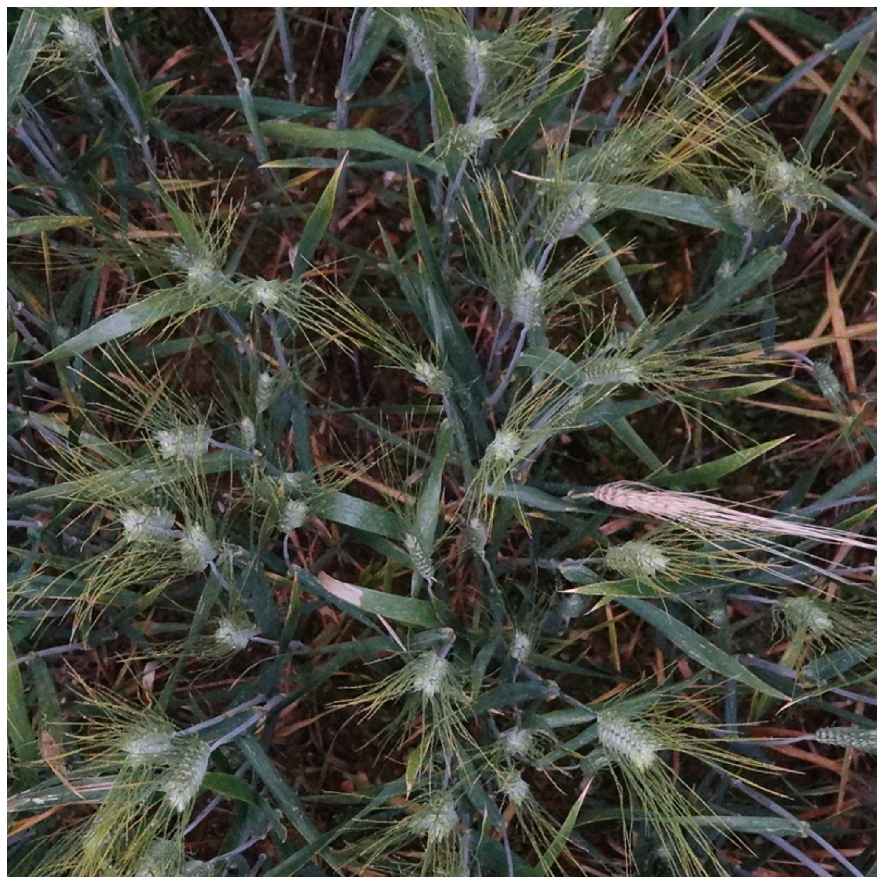

In [31]:
data = result.iloc[10]
image = generate_full_image(data, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])

show_image(image)

## Adjust the bounding boxes

In [32]:
COLORS = [(220, 0, 0), (0, 0, 220), (0, 220, 128), (220, 128, 0), (0, 220, 0), (128, 0, 128)]
OFFSETS = [(0, 0), (0, 1024), (1024, 0), (1024, 1024)]

def show_full_image_with_boxes(data):
    boxes = {}
    image = generate_full_image(data, rows=N_PATCH[TARGET][0], cols=N_PATCH[TARGET][1])

    for c in range(N_PATCH[TARGET][0] * N_PATCH[TARGET][1]):

        # Boxes for cell #c
        df = train_df[train_df['image_id'] == data[f'c{c+1}']][['x', 'y', 'x1', 'y1']]

        df['x'] = df['x'] + OFFSETS[c][0]
        df['x1'] = df['x1'] + OFFSETS[c][0]

        df['y'] = df['y'] + OFFSETS[c][1]
        df['y1'] = df['y1'] + OFFSETS[c][1]

        boxes[f'c{c+1}'] = df

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))

    i = 0
    for c in range(N_PATCH[TARGET][1]):
        for r in range(N_PATCH[TARGET][0]):
            bboxes = boxes[f'c{i+1}'].values.astype(np.uint32)

            for box in bboxes:
                cv2.rectangle(image, (box[0], box[1]),
                              (box[2], box[3]), COLORS[i], 2)

            i += 1

    ax.set_axis_off()
    ax.imshow(image)

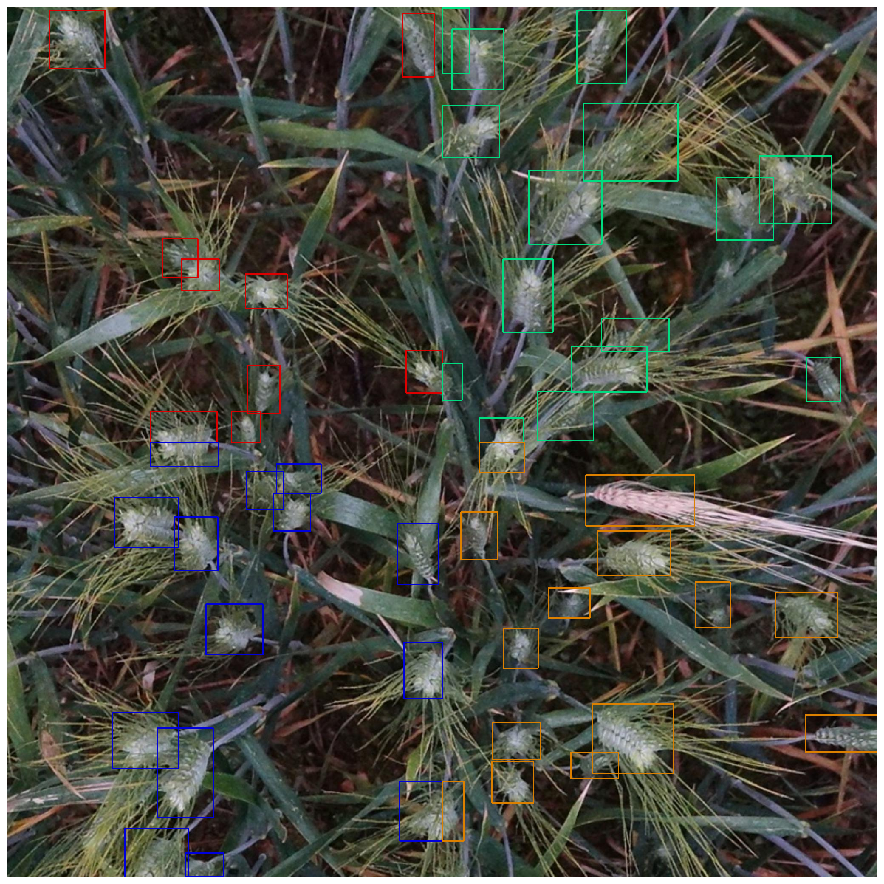

In [33]:
show_full_image_with_boxes(result.iloc[10])

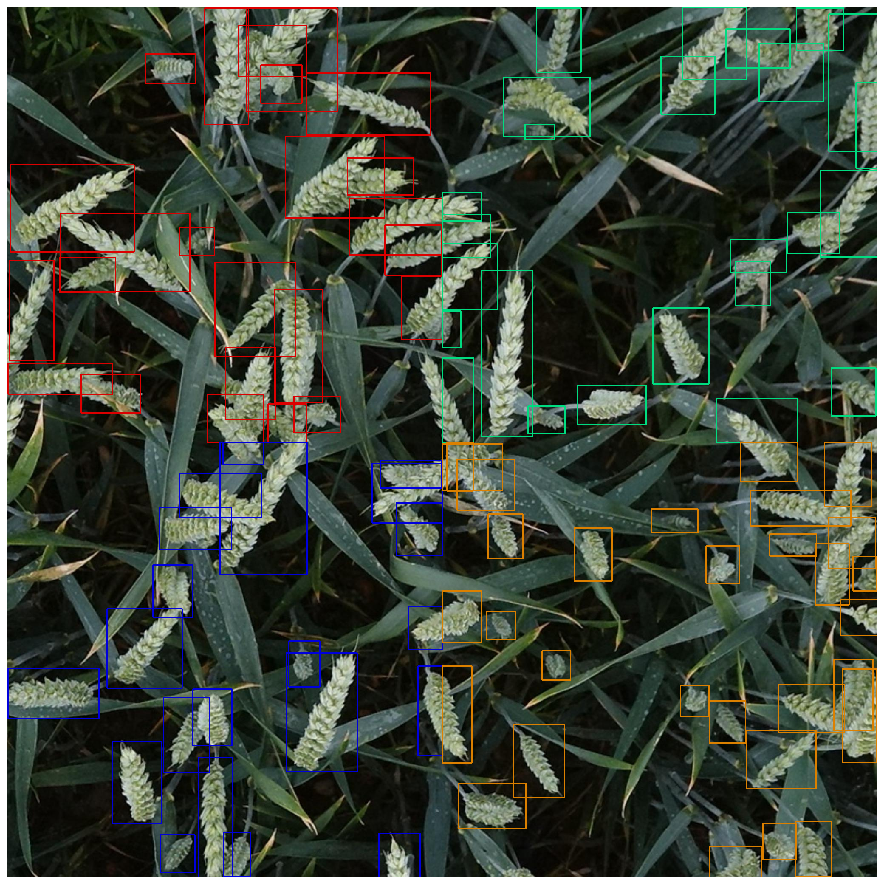

In [34]:
show_full_image_with_boxes(result.iloc[0])

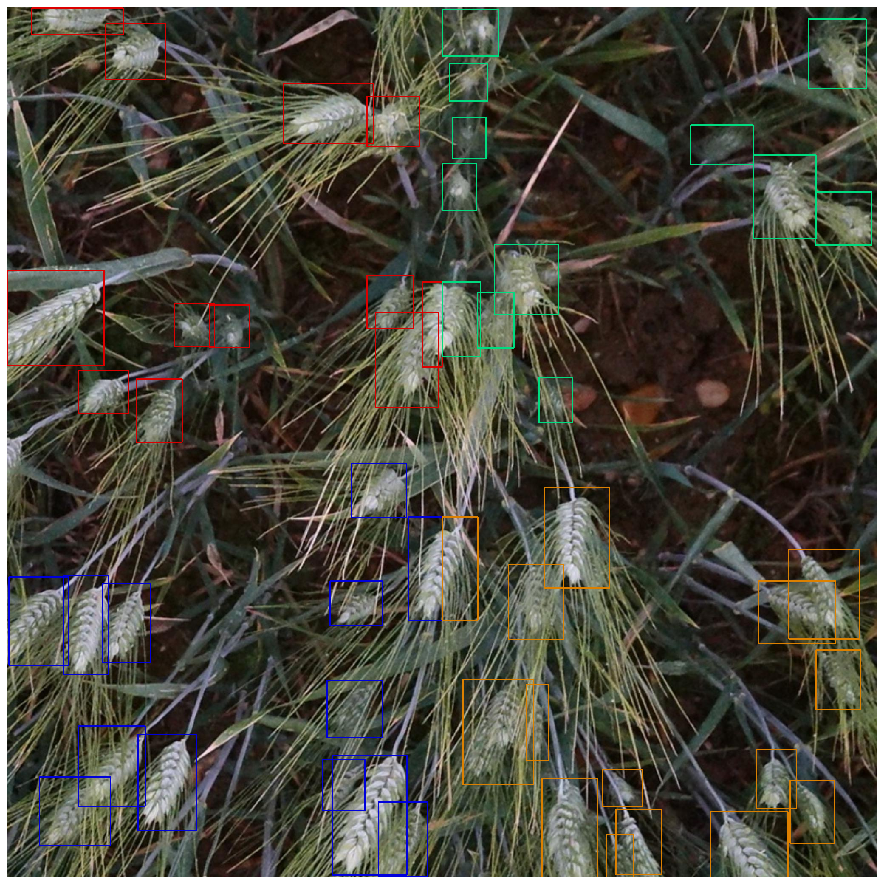

In [35]:
show_full_image_with_boxes(result.iloc[23])